# Отчёт о проведении эксперимента

  Исходные данные: датасеты `LUBM300`, `LUBM500`, `LUBM1.5M`, `LUBM1M`; графы взяты без изменений, регулярные выражения были предобработаны Vadim Abzalov et al. для их удобного распознавания библиотекой `pyformlang`.

  Замеры времени произведены на ЭВМ с установленной ОС Ubuntu 18.04. Технические характеристики: Intel Core i3-6006U 2.00 GHz (3072 KB cache), 8Gb DDR3 RAM.
  
  Для каждого замера в наносекундах запуск алгоритма производился 5 раз, в итоговую таблицу записано среднее из всех попыток, округлённое до миллисекунд. На графиках для большей репрезентативности время указано в секундах. Кэширование отключалось.
  
  Контрольные цифры - столбец `reachable_pairs` из сводного датафрейма. Это числа достижимых пар вершин в графе, полученном в пересечении исходного графа и регулярного выражения. Контрольные цифры совпадают как при построении транзитивного замыкания пересечения возвдением в квадрат, так и при умножении на матрицу смежности.

Регулярные выражения в результатах перегруппированы в 16 наборов, схожих по своей структуре, для более удобного восприятия информации на графиках.

Сводная таблица, полученная после запуска бенчмарков на пяти датасетах:

In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import re

sns.set(rc={'figure.figsize':(13,9)})


def group_regexes(regex_name):
    group_name = re.match('^q(_([0-9]*)|([0-9]*))_', regex_name).group().replace('_', '')
    if len(group_name) < 3:
        group_name = group_name.replace('q', 'q0')
    return group_name


df = pd.read_csv('benchmark_lubm.csv')
df['regex'] = df['regex'].apply(group_regexes)
df['closure_time_s'] = df['closure_time_ms'] / 1e3
df['intersection_time_s'] = df['intersection_time_ms'] / 1e3
df['inference_time_s'] = df['inference_time_ms'] / 1e3
df = df.drop(['inference_time_ms', 'closure_time_ms', 'intersection_time_ms'], axis=1)
df.head()

,algo,graph,regex,reachable_pairs,closure_time_s,intersection_time_s,inference_time_s
0,squaring,LUBM1.5M,q11,4416474,1.735,1.601,0.0
1,multiplying,LUBM1.5M,q11,4416474,1.676,1.601,0.0
2,squaring,LUBM1.5M,q09,635113,0.221,0.701,0.0
3,multiplying,LUBM1.5M,q09,635113,0.234,0.701,0.0
4,squaring,LUBM1.5M,q16,2432791,1.148,1.030,0.0


Время вывода пар во всех вычислениях было меньше одной миллисекунды:

In [27]:
df['inference_time_s'].value_counts()

0.0    2800
Name: inference_time_s, dtype: int64

Для предстaвления данных и сравнения времени работы алгоритмов построения замыкания через возведение в квадрат и умножение на матрицу смежности используется удобная форма графика - boxplot. На нем явно видно медиану (линия внутри "коробки"), 25% и 75% квартили (сама "коробка"), 2% и 98% процентиль ("усы"), а также возможные выбросы (точки, лежащие за "усами").

In [28]:
def get_boxplots_for_algo(graph_name, df):
    order = np.sort(df['regex'].unique())
    bp = sns.boxplot(x='regex', y='closure_time_s', order=order, hue='algo', data=df[df.graph == graph_name])
    bp.set_title(graph_name)
    bp.set(xlabel='Query', ylabel='Building closure time in seconds')
    return bp

### LUBM300

<AxesSubplot:title={'center':'LUBM300'}, xlabel='Query', ylabel='Building closure time in seconds'>

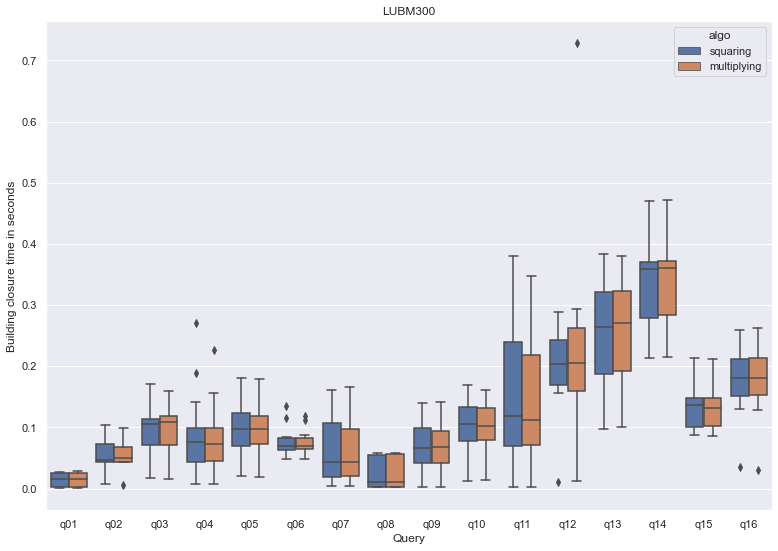

In [29]:
get_boxplots_for_algo('LUBM300', df)

### LUBM500

<AxesSubplot:title={'center':'LUBM500'}, xlabel='Query', ylabel='Building closure time in seconds'>

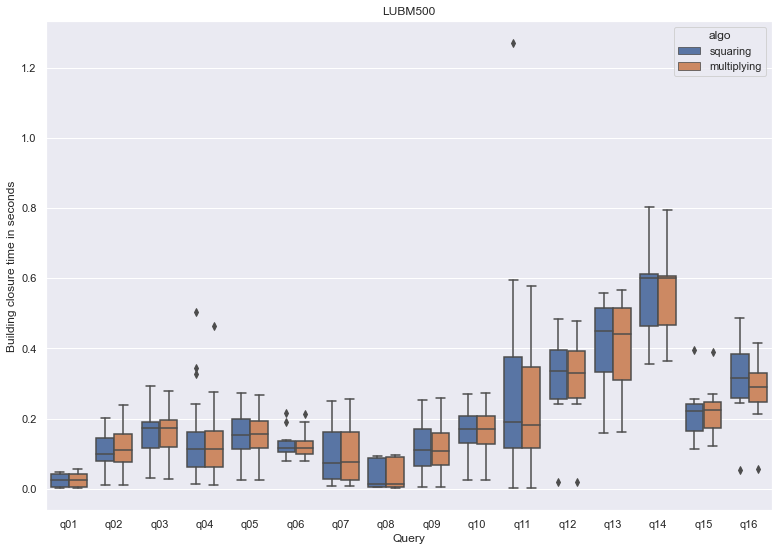

In [30]:
get_boxplots_for_algo('LUBM500', df)

### LUBM1M

<AxesSubplot:title={'center':'LUBM1M'}, xlabel='Query', ylabel='Building closure time in seconds'>

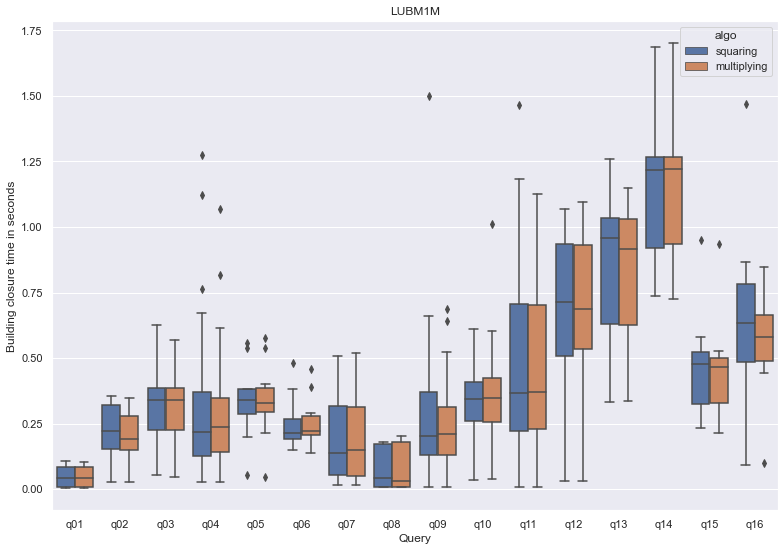

In [14]:
get_boxplots_for_algo('LUBM1M', df)

### LUBM1.5M

<AxesSubplot:title={'center':'LUBM1.5M'}, xlabel='Query', ylabel='Building closure time in seconds'>

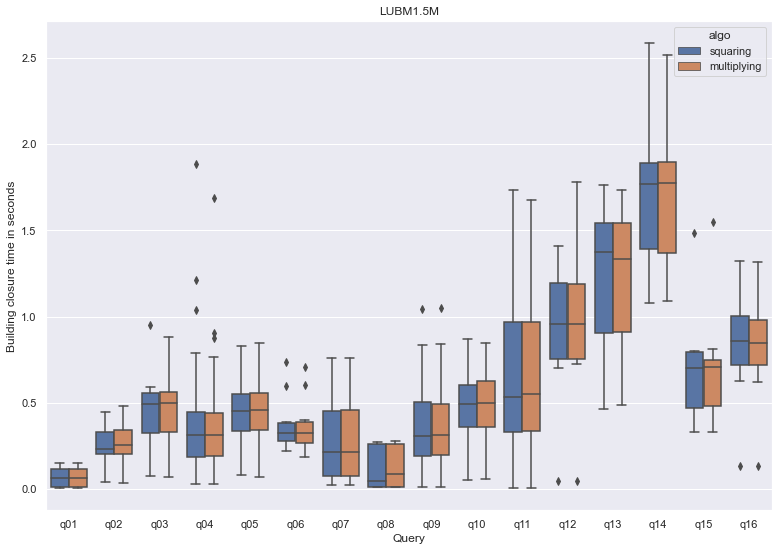

In [31]:
get_boxplots_for_algo('LUBM1.5M', df)

### LUBM1.9M

<AxesSubplot:title={'center':'LUBM1.9M'}, xlabel='Query', ylabel='Building closure time in seconds'>

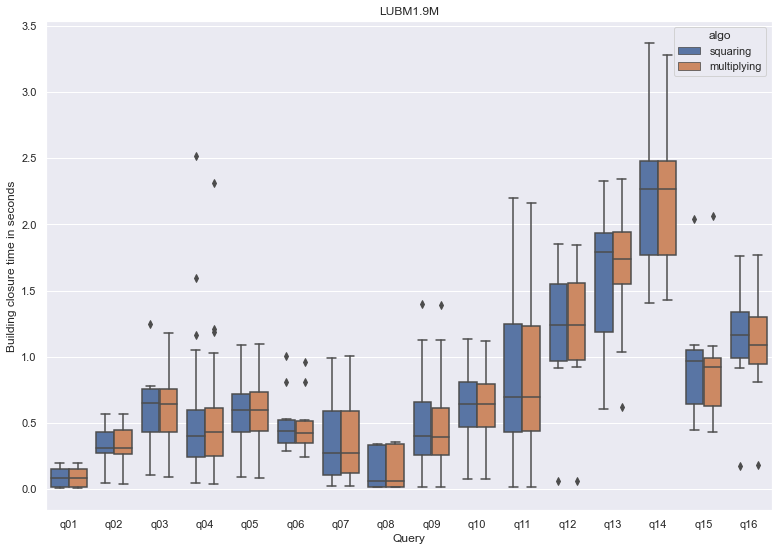

In [16]:
get_boxplots_for_algo('LUBM1.9M', df)

На графике снизу явно видна разница во времени вычисления тензороного произведения для разных датасетов с графами разного размера.

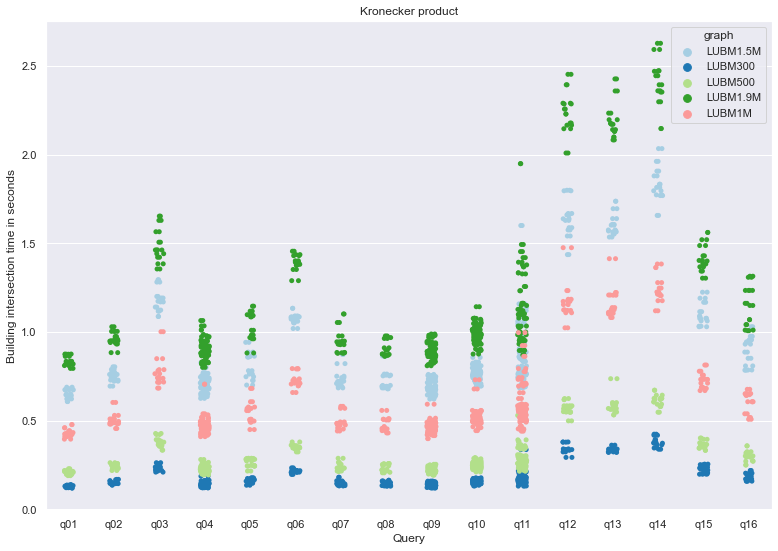

In [25]:
def get_stripplot_for_algo(df):
    order = np.sort(df['regex'].unique())
    sp = sns.stripplot(x='regex', y='intersection_time_s', order=order, hue='graph', data=df)
    sp.set_title('Kronecker product')
    sp.set(xlabel='Query', ylabel='Building intersection time in seconds')
    sns.set_palette("Paired")

get_stripplot_for_algo(df)

### Выводы

  На последнем графике со сравнением времени вычисления тензорного произведения на разных датасетах, равно как и на остальных, явно заметно, что запросы из групп q12, q13 и q14 вычисляются дольше остальных.
    
  Явной разницы между вычислением замыкания матрицы возведением в квадрат и умножением на матрицу смежности *не выявлено* - медианы во всех группах (равно как и сами выборки) практически совпадают, с точностью до незначительных флуктуаций. Объяснить это, конечно, можно хотя бы тем, что в первом случае происходит мало умножений, но на более плотные матрицы, а во втором - много умножений, но на очень разреженную матрицу смежности, и, скорее всего, в итоге время получается примерно одинаковым. 
  
  Хотелось бы ожидать, что на датасетах большего размера (замеры на которых на указанной машине произвести не удалось, в силу взрыва количества значений матрицы замыканий уже на 3ей итерации вычислений) разница будет более очевидной, но таковых выводов из указанных результатов сделать нельзя. Хотя отрицательный результат - тоже результат.